# Data Loading

In [177]:
import pandas as pd
import janitor
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [43]:
# -*- coding: utf-8 -*-
'''
a=pd.read_csv('ks-projects-201612.csv',encoding = "ISO-8859-1")
#remove empty columns
a_drop=[i for i in a.columns if 'Unnamed' in i]
a.drop(a_drop,axis=1,inplace=True)
'''
df=pd.read_csv('ks-projects-201801.csv',encoding = "ISO-8859-1")
#b.drop(['usd_pledged_real', 'usd_goal_real'],axis=1,inplace=True)
#%%


In [44]:
print(df.columns)
df.rename(columns={'usd pledged':'usd_pledged'},inplace=True)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


### data analysis + cleaning

In [45]:
#look for NaN
df.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

I suggest dropping the projects that do not have a name tag.

In [46]:
df = df.dropna(subset=['name'])
df.isna().sum()

ID                     0
name                   0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).
usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).
usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).

In 3797 cases Kickstarter did not convert the currency successfully to USD (usd_pledged)
Let us further investigate that issue.

In [47]:
#df where currency is USD, and USD_pledged differs from pledged even though the currency did not change
df[df['currency']=='USD'][['usd_pledged_real','usd_pledged','pledged','currency']][df['usd_pledged']!=df['pledged']].head(10)
#46581 entries seem to have a conversion error from USD to USD 
#so how many others are there? How do other currencies look? Is Fixer.io good?

C:\Users\vinde\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,usd_pledged_real,usd_pledged,pledged,currency
1,2421.00,100.0,2421.00,USD
29,57577.31,10120.0,57577.31,USD
31,47266.00,11253.0,47266.00,USD
41,2100.00,83.0,2100.00,USD
43,856.00,324.0,856.00,USD
51,6.00,5.0,6.00,USD
71,141.00,100.0,141.00,USD
102,1055.00,0.0,1055.00,USD
103,156.00,1.0,156.00,USD
106,22.00,7.0,22.00,USD


In [105]:
#number of unique currencies
print(df.currency.unique())

['GBP',
 'USD',
 'CAD',
 'AUD',
 'NOK',
 'EUR',
 'MXN',
 'SEK',
 'NZD',
 'CHF',
 'DKK',
 'HKD',
 'SGD',
 'JPY']

In [49]:
#Google 28.02.2020
to_usd={'GBP':1.29, 'USD':1, 'CAD':0.74, 'AUD':0.65, 'NOK':0.11, 'EUR':1.1, 'MXN':0.05, 'SEK':0.10, 'NZD':0.63,
       'CHF':1.04, 'DKK':0.15, 'HKD':0.13, 'SGD':0.72, 'JPY':0.0092}

#function to compare what Kickstarter sais he currency is vs what it should be with current exchange rate within in margin X%
# inf values from deviding by 0 were marked with NaN and then replaced with the mean ignoring the NaNs
def within_Xp(df,X,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged'):
    diff=df[col_base]*[to_usd[i] for i in df['currency']]/df[col_comp]
    diff.replace([np.inf, -np.inf], np.nan,inplace=True)
    diff.replace([np.nan], diff.mean(skipna=True),inplace=True)
    stats=[diff.mean(),diff.std(),len(diff[(diff>(1+X)) | (diff<(1-X))]),len(diff[(diff>(1+X)) | (diff<(1-X))])/len(df)]
    print(col_base,'vs',col_comp,'\nmean,std,,#out of dataset outside','1+-'+str(X),'%out of dataset outside','1+-'+str(X),'\n',stats)
    return diff[(diff>(1+X)) | (diff<(1-X))],stats

pledged vs usd_pledged 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [6.747186426901537, 429.6821928757306, 119393, 0.3153064646896796]


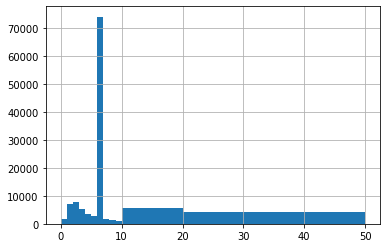

In [50]:
#Kickstarter conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged')
diff.hist(bins=[0,1,2,3,4,5,6,7,8,9,10,20,50])

In [51]:
# the big spike is the inf entries changed to the mean
# 30% of the data is not within boundaries

pledged vs usd_pledged_real 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [0.979746957209836, 0.05246349647943328, 622, 0.0016426475675875528]


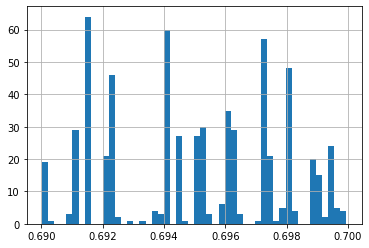

In [52]:
#Fixer.io conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged_real')
diff.hist(bins=50)

In [53]:
# at 40% there is no more outliers, so I believe it is best to drop pledged_usd and go with pledged_usd_real

In [54]:
df.drop(columns='usd_pledged',inplace=True)

In [55]:
#check for duplicates
df.duplicated().any()

False

In [56]:
#set datetime
df['launched']=pd.to_datetime(df['launched'])
df['deadline']=pd.to_datetime(df['deadline'])

## Categorical Features

In [57]:
#the categorical features and the contribution of the top 15 features to the data
for i in df.columns:
    print('\n',i,df[i].dtype)
    if df[i].dtype=='object' and i!='name':
        #print('# of categories in',i,len(df[i].unique()),'\n',df[i].unique())
        p={e:(df[i]==e).sum()/len(df) for e in df[i].unique()}
        p_sorted={k: v for k, v in sorted(p.items(), key=lambda item: item[1],reverse=True)}
        print({x:p_sorted[x] for c,x in enumerate(p_sorted) if c<15 },'\n')


 ID int64

 name object

 category object
{'Product Design': 0.05892668034659335, 'Documentary': 0.04262168664516964, 'Music': 0.04153363070007949, 'Tabletop Games': 0.03744813908101527, 'Shorts': 0.03263375561524018, 'Video Games': 0.031239353821532416, 'Food': 0.03035200722553657, 'Film & Video': 0.026694343429541776, 'Fiction': 0.024214526603231947, 'Fashion': 0.022590365423060976, 'Nonfiction': 0.021967110075873417, 'Art': 0.021795450764148027, 'Apparel': 0.018924778889601937, 'Theater': 0.0186369194284009, 'Technology': 0.018301523542414374} 


 main_category object
{'Film & Video': 0.16791977964226198, 'Music': 0.13711089455628708, 'Publishing': 0.10530374454981685, 'Games': 0.09303934695515995, 'Technology': 0.08601187882437139, 'Design': 0.07940959760416419, 'Art': 0.07434696836450931, 'Food': 0.06497172903181507, 'Fashion': 0.06025505932809905, 'Theater': 0.028820277982448496, 'Comics': 0.028572032208568705, 'Photography': 0.02846639570904539, 'Crafts': 0.02326379810752211, '

In [58]:
state_p={i:(df.state==i).sum()/len(df) for i in df.state.unique()}
state_p_sorted={k: v for k, v in sorted(state_p.items(), key=lambda item: item[1],reverse=True)}

print(state_p_sorted)

{'failed': 0.5221506534937952, 'successful': 0.3537660732536306, 'canceled': 0.10241194537536609, 'undefined': 0.009406930282551226, 'live': 0.007391914054143988, 'suspended': 0.004872483540512918}


https://www.kaggle.com/kemical/kickstarter-projects/discussion/67067
This user hinted that there are successful project without backers
We will remove them

In [59]:
print('0 backers and succeeded:',((df.backers==0)&(df.state=='successful')).sum())
df[(df.backers==0)&(df.state=='successful')].country.unique()
df=df[~((df.backers==0)&(df.state=='successful'))]

0 backers and succeeded: 105


In [60]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [61]:
country_p={i:(df.country==i).sum()/len(df) for i in df.country.unique()}
country_p_sorted={k: v for k, v in sorted(country_p.items(), key=lambda item: item[1],reverse=True)}

print(country_p_sorted)

{'US': 0.7730087279950971, 'GB': 0.08894682896933578, 'CA': 0.038980113696401024, 'AU': 0.020707855195587398, 'DE': 0.01101830131659587, 'N,0"': 0.00975295335911579, 'FR': 0.007763794670217037, 'IT': 0.007602654324901203, 'NL': 0.007576237874849426, 'ES': 0.006012384031784273, 'SE': 0.004641370274097086, 'MX': 0.0046281620490711975, 'NZ': 0.0038224603224920224, 'DK': 0.0029401508907626957, 'IE': 0.0021423740991990533, 'CH': 0.002010291848940172, 'NO': 0.001870284663665758, 'HK': 0.0016325366131997717, 'BE': 0.0016298949681945942, 'AT': 0.0015770620680910417, 'SG': 0.0014661129778735815, 'LU': 0.0001637819903210127, 'JP': 0.00010566580020710496}


In [62]:
test = df[df['ID'] == 948525980]

print('Empty??', test.isna().sum())

Empty?? ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


In [63]:
test

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
368719,948525980,Oceanus -\tA game like no other.,Video Games,Games,USD,2014-02-23,40000.0,2014-01-24 04:55:18,20.0,failed,8,US,20.0,40000.0


In [64]:
sum1 = df[['backers', 'usd_pledged_real', 'usd_goal_real']]
summary1 = {}
for columns in sum1.columns:
    summary1.update({columns : pd.Series([df[columns].count() - len(df.index), df[columns].mean(), df[columns].median(),
    df[columns].std(), df[columns].min(), df[columns].max(), df[columns].mode()])})
summary1 = pd.DataFrame(summary1)
print(summary1)

               backers         usd_pledged_real               usd_goal_real
0                    0                        0                           0
1              105.648                  9053.01                     45465.2
2                   12                   623.35                        5500
3              907.314                  90876.3                 1.15312e+06
4                    0                        0                        0.01
5               219382               2.0339e+07                 1.66361e+08
6  0    0
dtype: int64  0    0.0
dtype: float64  0    5000.0
dtype: float64


[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A47B0A6940>]]


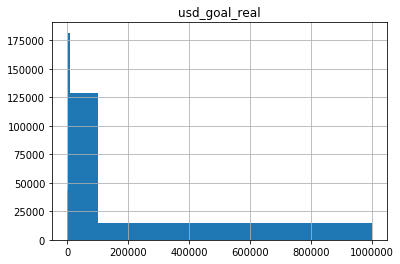

In [188]:
sum2 = df[['usd_goal_real']]

hist = sum2.hist(bins = [0,10,100,1000, 10000, 100000,1000000])
print(hist)



0     3.186094
1     4.477136
2     4.653222
3     3.699057
4     4.290057
5     4.698979
6     3.000434
7     4.397957
8     5.096913
9     4.812920
10    3.381546
11    4.096945
12    3.699057
13    5.301032
14    3.810953
15    3.398114
16    3.176381
17    3.477266
18    2.399674
19    3.699057
Name: usd_goal_real, dtype: float64
stdev 0.7375053660295954
mean 3.752965590339756


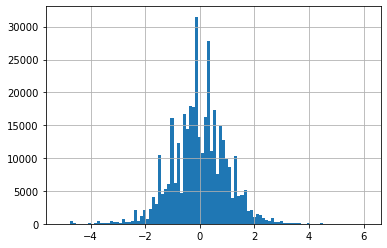

In [230]:
a = df['usd_goal_real']
a = a+1
a = np.log10(a)
print(a.head(20))

stdev = a.std()
print('stdev', stdev)
mean = a.mean()
print('mean', mean)
a = (a-mean)/stdev
a.hist(bins = 100)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A473D28438>]]


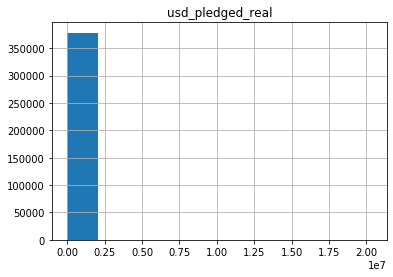

In [96]:
sum2 = df[['usd_pledged_real']]
a.hist(bins = 100)#sum2 = sum2[sum2['pledged_real']]
hist = sum2.hist()
print(hist)

In [111]:
categorical = df[['category', 'main_category', 'currency', 'state']]

u_category = list(categorical.category.unique())
u_main_category = list(categorical.main_category.unique())
u_currency = list(categorical.currency.unique())
u_state = list(categorical.state.unique())

unique = list(u_category, u_main_category, u_currency, u_state)

print(categorical.columns)

TypeError: list expected at most 1 arguments, got 4

In [122]:
test = df[(df['country'] == 'US') & (df['state'] == 'successful')]
print(test)

                ID                                               name  \
5       1000014025                               Monarch Espresso Bar   
6       1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
11       100005484                                   Lisa Lim New CD!   
18      1000070642                Mike Corey's Darkness & Light Album   
20      1000072011              CMUK. Shoes: Take on Life Feet First.   
24      1000091520                        The Book Zoo - A Mini-Comic   
25      1000102741  Matt Cavenaugh & Jenny Powers make their 1st a...   
29       100011318                      My Moon - Animated Short Film   
31      1000117861                  Ledr workbook: one tough journal!   
34       100012079            Chris Eger Band - New Nashville Record!   
36      1000131947                         Arrows & Sound Debut Album   
37      1000132945  Zen in America: a film on Zen Buddhism in Nort...   
39      1000146991             Help Scott Reynolds 

In [168]:
plot_dict = {}
def cat_plots(attribute, df):
    for cat in df[attribute].unique():    
        success = df[(df[attribute] == cat) & (df['state'] == 'successful')]
        fail = df[(df[attribute] == cat) & (df['state'] == 'failed')]
        plot_dict.update({cat : [len(success.index), len(fail.index)]})
    
    
    labels = list()
    s = list()
    f = list()
    for key in plot_dict:
        labels.append(key)
        s.append(plot_dict[key][0]/(plot_dict[key][0] + plot_dict[key][1])*100)
        f.append(plot_dict[key][1]/(plot_dict[key][0] + plot_dict[key][1])*100)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, s, width, label='Success')
    rects2 = ax.bar(x + width/2, f, width, label='Fail')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('%')
    ax.set_title('Success/fail ratio for ' + attribute)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()        


    fig.tight_layout()

    plt.show()
   

In [169]:

indexNames = df[df['country'] == 'N,0"'].index
df.drop(indexNames , inplace=True)

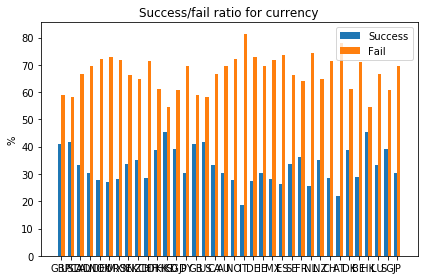

In [173]:
cat_plots('currency', df)

0.01 166361390.71


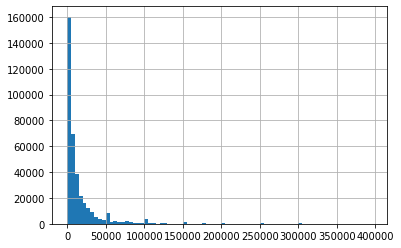

In [224]:
b = df['usd_goal_real']
b.hist(bins = range(0,400000,5000))
print(b.min(), b.max())

c = (b-b.min())/(b.max()-b.min())
#c.hist(bins = 2)